In [292]:
from matplotlib import pyplot
import numpy as np
from pandas import DataFrame
import pandas as pd
import psycopg2 as pq
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import yaml


with open(r'../../config/database.yml') as file:
    database_connection = yaml.load(file, Loader=yaml.FullLoader)

conn = pq.connect("dbname=" + database_connection['development']['database'])
cur = conn.cursor()
cur.execute("""
Select
CU.name,
IT.item_number,
IT.item_description,
'Each' as unit_of_measure,
SA.sales_date - (date_part('day', SA.sales_date) - 1)::integer as sales_date,
sum(SA.sales_quantity * IUOM.base_conversion) as sales_quantity

From
sales SA
  Join customers CU
    On CU.id = SA.customer_id
  Join items IT
    On IT.id = SA.item_id
  Join unit_of_measures UOM
    On UOM.id = SA.unit_of_measure_id
  Join item_unit_of_measures IUOM
    On IUOM.item_id = SA.item_id and IUOM.unit_of_measure_id = SA.unit_of_measure_id
    
Where
IT.item_number = 'CCDK100150'

Group by
CU.name,
IT.item_number,
IT.item_description,
UOM.code,
SA.sales_date - (date_part('day', SA.sales_date) - 1)::integer;
""")

items = cur.fetchall()

col_names = []
for header in cur.description:
    col_names.append(header[0])

cur.close()
conn.close()

data_frame = DataFrame(items, columns=col_names)
data_frame.set_index('sales_date', inplace=True)
data_frame.head(5)

,name,item_number,item_description,unit_of_measure,sales_quantity
sales_date,,,,,
2018-01-01,Costco Wholesale Corporation,CCDK100150,Original Canine 50#,Each,74470
2018-02-01,Costco Wholesale Corporation,CCDK100150,Original Canine 50#,Each,66490
2018-03-01,Costco Wholesale Corporation,CCDK100150,Original Canine 50#,Each,78730
2018-04-01,Costco Wholesale Corporation,CCDK100150,Original Canine 50#,Each,62120
2018-05-01,Costco Wholesale Corporation,CCDK100150,Original Canine 50#,Each,71420


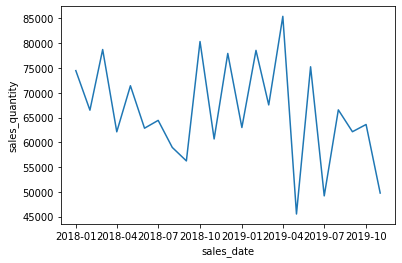

In [293]:
pyplot.xlabel('sales_date')
pyplot.ylabel('sales_quantity')
pyplot.plot(data_frame[['sales_quantity']])

In [294]:
rolmean = data_frame[['sales_quantity']].rolling(window=12).mean()
rolstd = data_frame[['sales_quantity']].rolling(window=12).std()

print(rolmean)
print(rolstd)

            sales_quantity
sales_date                
2018-01-01             NaN
2018-02-01             NaN
2018-03-01             NaN
2018-04-01             NaN
2018-05-01             NaN
2018-06-01             NaN
2018-07-01             NaN
2018-08-01             NaN
2018-09-01             NaN
2018-10-01             NaN
2018-11-01             NaN
2018-12-01    67891.250000
2019-01-01    66934.583333
2019-02-01    67940.416667
2019-03-01    67008.750000
2019-04-01    68951.250000
2019-05-01    66793.750000
2019-06-01    67827.083333
2019-07-01    66557.083333
2019-08-01    67188.750000
2019-09-01    67679.583333
2019-10-01    66284.166667
2019-11-01    65374.166667
            sales_quantity
sales_date                
2018-01-01             NaN
2018-02-01             NaN
2018-03-01             NaN
2018-04-01             NaN
2018-05-01             NaN
2018-06-01             NaN
2018-07-01             NaN
2018-08-01             NaN
2018-09-01             NaN
2018-10-01             NaN
2

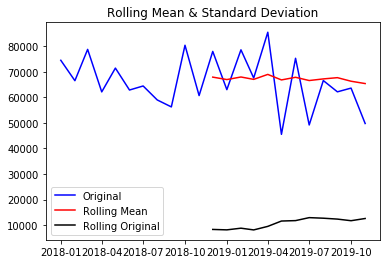

In [295]:
orig = pyplot.plot(data_frame[['sales_quantity']], color='blue', label='Original')
mean = pyplot.plot(rolmean, color='red', label='Rolling Mean')
std = pyplot.plot(rolstd, color='black', label='Rolling Original')
pyplot.legend(loc='best')
pyplot.title('Rolling Mean & Standard Deviation')
pyplot.show(block=False)

In [296]:
dftest = adfuller(data_frame['sales_quantity'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                 -2.656770
p-value                         0.081822
#Lags Used                      9.000000
Number of Observations Used    13.000000
Critical Value (1%)            -4.068854
Critical Value (5%)            -3.127149
Critical Value (10%)           -2.701730
dtype: float64


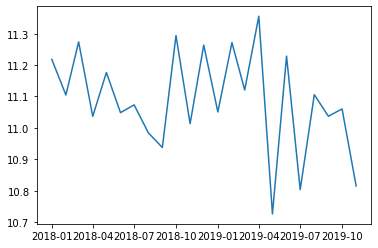

In [297]:
data_frame_logScale = np.log(data_frame[['sales_quantity']])
pyplot.plot(data_frame_logScale)

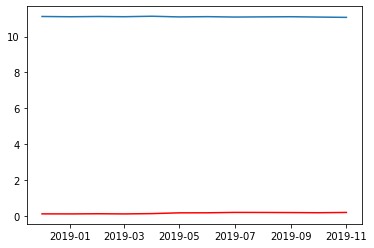

In [298]:
movingAverage = data_frame_logScale.rolling(window=12).mean()
movingSTD = data_frame_logScale.rolling(window=12).std()
pyplot.plot(movingAverage)
pyplot.plot(movingSTD, color='red')

In [299]:
logScale_minus_movingAverage = data_frame_logScale - movingAverage
logScale_minus_movingAverage.dropna(inplace=True)

logScale_minus_movingAverage.head(10)

,sales_quantity
sales_date,
2018-12-01,0.144925
2019-01-01,-0.054086
2019-02-01,0.152900
2019-03-01,0.014668
2019-04-01,0.222945
2019-05-01,-0.368864
2019-06-01,0.118575
2019-07-01,-0.284060
2019-08-01,0.008126
